In [23]:
import torch
import torch
import torch.nn as nn
from torch.nn import Linear, Conv2d, BatchNorm1d, BatchNorm2d, PReLU, Sequential, Module
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import torch.optim as optim
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# device = torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


In [24]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
import torch

class RAFDBDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.img_dir, self.labels.iloc[idx, 0])
        image = Image.open(img_name)
        label = self.labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)

        return image, label

In [25]:
from get_dataset import GiMeFiveDataset

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # transforms.RandomErasing(scale=(0.02,0.25)),
])
    
# rafdb_dataset_train = GiMeFiveDataset(csv_file='archive/RAF-DB/train_RAF_labels.csv',
#                             img_dir='archive/RAF-DB/train/',
#                             transform=transform)

rafdb_dataset_train = GiMeFiveDataset(csv_file='archive/FER2013/train_FER_labels.csv',
                            img_dir='archive/FER2013/train/',
                            transform=transform)

# rafdb_dataset_train = GiMeFiveDataset(csv_file='data/train_labels.csv',
#                             img_dir='data/train/',
#                             transform=transform)
data_train_loader = DataLoader(rafdb_dataset_train, batch_size=16, shuffle=True, num_workers=4)
train_image, train_label = next(iter(data_train_loader))
print(f"Train batch: image shape {train_image.shape}, labels shape {train_label.shape}")

rafdb_dataset_vali = GiMeFiveDataset(csv_file='data/valid_labels.csv',
                            img_dir='data/valid',
                            transform=transform)
data_vali_loader = DataLoader(rafdb_dataset_vali, batch_size=16, shuffle=False, num_workers=0)
vali_image, vali_label = next(iter(data_vali_loader))
print(f"Vali batch: image shape {vali_image.shape}, labels shape {vali_label.shape}")

# rafdb_dataset_test = GiMeFiveDataset(csv_file='archive/RAF-DB/test_RAF_labels.csv',
#                             img_dir='archive/RAF-DB/test/',
#                             transform=transform)

rafdb_dataset_test = GiMeFiveDataset(csv_file='archive/FER2013/test_FER_labels.csv',
                            img_dir='archive/FER2013/test/',
                            transform=transform)

# rafdb_dataset_test = GiMeFiveDataset(csv_file='data/test_labels.csv',
#                             img_dir='data/test/',
#                             transform=transform)
data_test_loader = DataLoader(rafdb_dataset_test, batch_size=16, shuffle=False, num_workers=0)
test_image, test_label = next(iter(data_test_loader))
print(f"Test batch: image shape {test_image.shape}, labels shape {test_label.shape}")

Train batch: image shape torch.Size([16, 3, 64, 64]), labels shape torch.Size([16])
Vali batch: image shape torch.Size([16, 3, 64, 64]), labels shape torch.Size([16])
Test batch: image shape torch.Size([16, 3, 64, 64]), labels shape torch.Size([16])


In [26]:
import torch.nn as nn
import torch.nn.functional as F

class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        
        self.dropout1 = nn.Dropout(0.2)
        
        self.classifier = nn.Sequential(
            nn.Linear(16384, 4096), 
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 6)  
        )

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn1(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv3(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.conv4(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn3(self.conv5(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn3(self.conv6(x)))
        x = F.max_pool2d(x, 2)
        
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = VGG16().to(device)

In [27]:
# model.load_state_dict(torch.load('best_baseline.pth', map_location=device))
# model.eval()

In [28]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 72460742


In [29]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.Adam(model.parameters(), lr=0.001, amsgrad=True)
# optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)


patience = 10
best_val_acc = 0  
patience_counter = 0

num_epochs = 80

In [30]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data in tqdm(data_train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(data_train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    test_running_loss = 0.0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for data in data_test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_loss = test_running_loss / len(data_test_loader)
    test_acc = test_correct / test_total
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for data in data_vali_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(data_vali_loader)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Train Accuracy: {train_acc}, Test Loss: {test_loss}, Test Accuracy: {test_acc}, Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0 
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        print(f"No improvement in validation accuracy for {patience_counter} epochs.")
    
    if patience_counter > patience:
        print("Stopping early due to lack of improvement in validation accuracy.")
        break

Epoch 1/80: 100%|██████████| 1484/1484 [01:58<00:00, 12.50it/s]


Epoch 1, Train Loss: 1.5270441611099115, Train Accuracy: 0.36038920011793946, Test Loss: 1.4779940268365286, Test Accuracy: 0.4199192462987887, Validation Loss: 2.0065164942490425, Validation Accuracy: 0.18697829716193656


Epoch 2/80: 100%|██████████| 1484/1484 [01:56<00:00, 12.69it/s]


Epoch 2, Train Loss: 1.289742333990223, Train Accuracy: 0.47689650815045703, Test Loss: 1.5229949821387567, Test Accuracy: 0.38896366083445494, Validation Loss: 1.896426869066138, Validation Accuracy: 0.24540901502504173


Epoch 3/80: 100%|██████████| 1484/1484 [01:58<00:00, 12.52it/s]


Epoch 3, Train Loss: 1.1821385591097597, Train Accuracy: 0.5291689482330146, Test Loss: 1.4140685625294203, Test Accuracy: 0.47947510094212653, Validation Loss: 1.7414162504045587, Validation Accuracy: 0.3121869782971619


Epoch 4/80: 100%|██████████| 1484/1484 [01:57<00:00, 12.63it/s]


Epoch 4, Train Loss: 1.1147287965744654, Train Accuracy: 0.5555368350111621, Test Loss: 1.3489908136988198, Test Accuracy: 0.49411170928667564, Validation Loss: 1.7501720472386009, Validation Accuracy: 0.31385642737896496


Epoch 5/80: 100%|██████████| 1484/1484 [01:55<00:00, 12.90it/s]


Epoch 5, Train Loss: 1.0654289254321243, Train Accuracy: 0.5768080535781981, Test Loss: 1.3915593322887216, Test Accuracy: 0.46315612382234184, Validation Loss: 1.6846882418582314, Validation Accuracy: 0.337228714524207


Epoch 6/80: 100%|██████████| 1484/1484 [01:55<00:00, 12.88it/s]


Epoch 6, Train Loss: 1.0229208593098622, Train Accuracy: 0.5955941198770061, Test Loss: 1.3917643908531434, Test Accuracy: 0.4781292059219381, Validation Loss: 1.6258370092040615, Validation Accuracy: 0.3555926544240401


Epoch 7/80: 100%|██████████| 1484/1484 [01:54<00:00, 12.91it/s]


Epoch 7, Train Loss: 0.9960923806194346, Train Accuracy: 0.6062507897729666, Test Loss: 1.418942231324411, Test Accuracy: 0.4539030955585464, Validation Loss: 1.7308632794179415, Validation Accuracy: 0.3071786310517529
No improvement in validation accuracy for 1 epochs.


Epoch 8/80: 100%|██████████| 1484/1484 [01:55<00:00, 12.90it/s]


Epoch 8, Train Loss: 0.9658528857555673, Train Accuracy: 0.6165283686449602, Test Loss: 1.4362579536053441, Test Accuracy: 0.4152086137281292, Validation Loss: 1.79834540894157, Validation Accuracy: 0.2988313856427379
No improvement in validation accuracy for 2 epochs.


Epoch 9/80: 100%|██████████| 1484/1484 [01:54<00:00, 12.91it/s]


Epoch 9, Train Loss: 0.9403140820020613, Train Accuracy: 0.6301335242828862, Test Loss: 1.476224626424492, Test Accuracy: 0.36507402422611035, Validation Loss: 1.8847386837005615, Validation Accuracy: 0.27212020033388984
No improvement in validation accuracy for 3 epochs.


Epoch 10/80: 100%|██████████| 1484/1484 [01:55<00:00, 12.90it/s]


Epoch 10, Train Loss: 0.9157735883908452, Train Accuracy: 0.6415904974516659, Test Loss: 1.4554202787337764, Test Accuracy: 0.38341184387617766, Validation Loss: 1.8568385996316608, Validation Accuracy: 0.27212020033388984
No improvement in validation accuracy for 4 epochs.


Epoch 11/80: 100%|██████████| 1484/1484 [01:54<00:00, 12.97it/s]


Epoch 11, Train Loss: 0.8939665348904152, Train Accuracy: 0.6514047428499221, Test Loss: 1.5767528722363133, Test Accuracy: 0.3149394347240915, Validation Loss: 1.812235973383251, Validation Accuracy: 0.2938230383973289
No improvement in validation accuracy for 5 epochs.


Epoch 12/80: 100%|██████████| 1484/1484 [01:54<00:00, 12.97it/s]


Epoch 12, Train Loss: 0.8765790051406606, Train Accuracy: 0.6547744408407397, Test Loss: 1.4783492645909708, Test Accuracy: 0.3598586810228802, Validation Loss: 1.9238150308006687, Validation Accuracy: 0.27212020033388984
No improvement in validation accuracy for 6 epochs.


Epoch 13/80: 100%|██████████| 1484/1484 [01:54<00:00, 12.94it/s]


Epoch 13, Train Loss: 0.8609577805366156, Train Accuracy: 0.6605029274251295, Test Loss: 1.6027378483164696, Test Accuracy: 0.32351951547779273, Validation Loss: 1.961110908734171, Validation Accuracy: 0.3088480801335559
No improvement in validation accuracy for 7 epochs.


Epoch 14/80: 100%|██████████| 1484/1484 [01:54<00:00, 12.99it/s]


Epoch 14, Train Loss: 0.8370466656239849, Train Accuracy: 0.6701908091487301, Test Loss: 1.5005517153329746, Test Accuracy: 0.35010094212651416, Validation Loss: 1.8532404868226302, Validation Accuracy: 0.3105175292153589
No improvement in validation accuracy for 8 epochs.


Epoch 15/80: 100%|██████████| 1484/1484 [01:54<00:00, 13.01it/s]


Epoch 15, Train Loss: 0.8200570870984115, Train Accuracy: 0.6773514173792173, Test Loss: 1.512906957217442, Test Accuracy: 0.3415208613728129, Validation Loss: 1.8083859493857937, Validation Accuracy: 0.3121869782971619
No improvement in validation accuracy for 9 epochs.


Epoch 16/80: 100%|██████████| 1484/1484 [01:55<00:00, 12.88it/s]


Epoch 16, Train Loss: 0.8036584376164202, Train Accuracy: 0.6820268733414768, Test Loss: 1.3825557233505352, Test Accuracy: 0.4468371467025572, Validation Loss: 1.8186684188089872, Validation Accuracy: 0.32053422370617696
No improvement in validation accuracy for 10 epochs.


Epoch 17/80: 100%|██████████| 1484/1484 [01:54<00:00, 12.94it/s]


Epoch 17, Train Loss: 0.7853716169948366, Train Accuracy: 0.6900720272945537, Test Loss: 1.4981295950310205, Test Accuracy: 0.35447510094212653, Validation Loss: 1.8198407543332953, Validation Accuracy: 0.29549248747913187
No improvement in validation accuracy for 11 epochs.
Stopping early due to lack of improvement in validation accuracy.


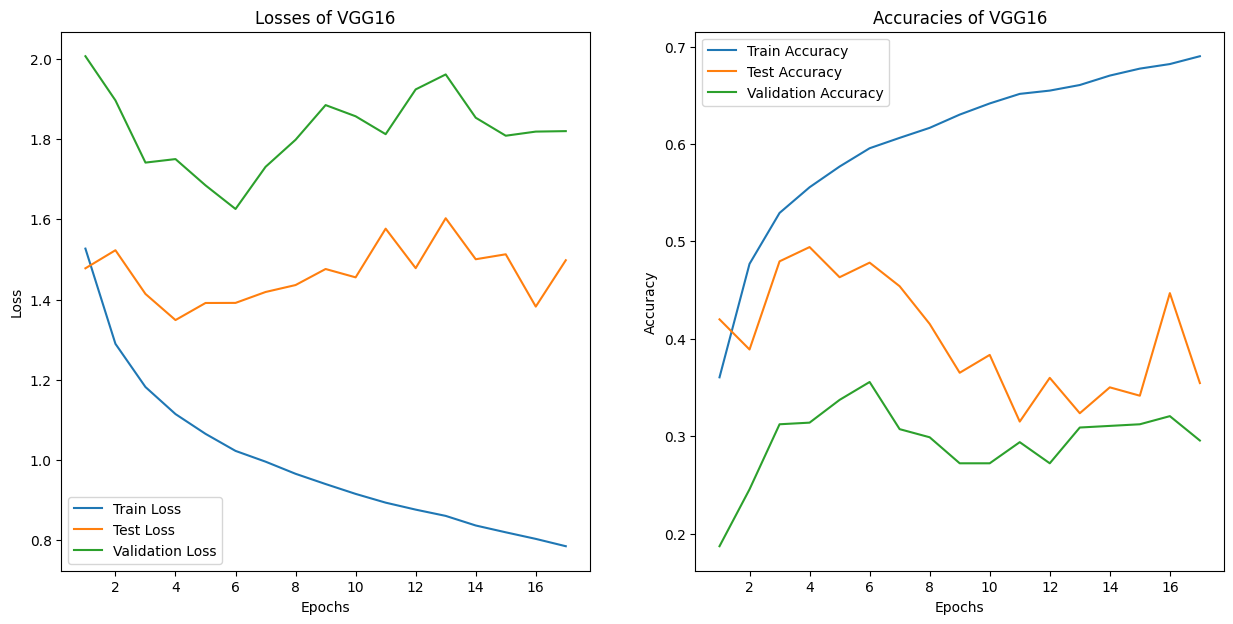

In [32]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(range(1, 18), train_losses, label='Train Loss') # change this number after '(1, _)' to num_epochs+1
plt.plot(range(1, 18), test_losses, label='Test Loss') # change this number after '(1, _)' to num_epochs+1
plt.plot(range(1, 18), val_losses, label='Validation Loss') # change this number after '(1, _)' to num_epochs+1
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Losses of VGG16') # change
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, 18), train_accuracies, label='Train Accuracy') # change this number after '(1, _)' to num_epochs+1
plt.plot(range(1, 18), test_accuracies, label='Test Accuracy') # change this number after '(1, _)' to num_epochs+1
plt.plot(range(1, 18), val_accuracies, label='Validation Accuracy') # change this number after '(1, _)' to num_epochs+1
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracies of VGG16') # change
plt.legend()

plt.show()

In [ ]:
df = pd.DataFrame({
    'Epoch': range(1, 18), # change this number after '(1, _)' to num_epochs+1
    'Train Loss': train_losses,
    'Test Loss': test_losses,
    'Validation Loss': val_losses,
    'Train Accuracy': train_accuracies,
    'Test Accuracy': test_accuracies,
    'Validation Accuracy': val_accuracies
})
df.to_csv('result_vgg_fer.csv', index=False) # change this CSV